## Imports

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import requests
import pandas as pd
import time
import operator
import re
import cufflinks as cf
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from plotly import graph_objs as go

In [3]:
cf.go_offline()

## Idea for the project.

For this week project we start to visualize the data in order to get some insights or in the better case to get ideas about new hypothesis in the data. Considering that we have to be careful at decision's time, and **don't** take any decision just after see a plot.

The idea what I decided to explore was the impact of Donald Trump tweets over the classic pair of currency EUR/USD, in the 15 minutes timeframe prices, and beetwen the lapse 01.01.2015 to 31.12.2018

# Getting the data.

I found a siteweb where all the tweets of Donald Trump are available for download: 
* http://www.trumptwitterarchive.com/

And for the EUR/USD pair of currencies, some months ago I got data from a specialized software on trading in the period 2017-01-02 to 2018-01-02, for the 15 minutes timeframe.

In [55]:
# I load the data about pair EUR/USD
data_eurusd_1 = pd.read_csv('./Data/EURUSD_M15_201701020800_201801021715.csv',sep='\t')

## Exploratory Data Analysis.

In [56]:
# Checking the structure for the dataset.
data_eurusd_1.head(5)

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
0,2017.01.02,08:00:00,1.05200,1.05232,1.05195,1.05227,245,293000000,28
1,2017.01.02,08:15:00,1.05227,1.05227,1.05197,1.05202,173,178000000,51
2,2017.01.02,08:30:00,1.05202,1.05242,1.05181,1.05193,3460,4315000000,25
3,2017.01.02,08:45:00,1.05193,1.05194,1.05128,1.05156,763,1078000000,25
4,2017.01.02,09:00:00,1.05156,1.05189,1.05152,1.05162,2710,3107000000,28


In [57]:
print('Se tienen %i registros.' % data_eurusd_1.shape[0])

Se tienen 24812 registros.


In [58]:
# Exploring types of data.
data_eurusd_1.dtypes

<DATE>        object
<TIME>        object
<OPEN>       float64
<HIGH>       float64
<LOW>        float64
<CLOSE>      float64
<TICKVOL>      int64
<VOL>          int64
<SPREAD>       int64
dtype: object

In [59]:
# Searching for null values.
missing_values = data_eurusd_1.isna().sum()
missing_values

<DATE>       0
<TIME>       0
<OPEN>       0
<HIGH>       0
<LOW>        0
<CLOSE>      0
<TICKVOL>    0
<VOL>        0
<SPREAD>     0
dtype: int64

## Data cleaning and manipulation.

In [61]:
# In order to get a better manage for time and date attributes, I created different columns for Date (Year,Month,Day)
# Time (Hour,Minutes) this is not the best aproach but is more understandable to me. 

def generate_date(x):
    date = x.split('.')
    return datetime(year=int(date[0]), month=int(date[1]), day=int(date[2]))

def generate_year(x):
    date = x.split('.')
    return int(date[0])

def generate_month(x):
    date = x.split('.')
    return int(date[1])

def generate_hour(x):
    hour_minutes = x.split(':')
    return hour_minutes[0]

def generate_minutes(x):
    hour_minutes = x.split(':')
    return hour_minutes[1]

def generate_weekday_weekend(x):
    return x.isoweekday()


data_eurusd_1['Hour'] = data_eurusd_1['<TIME>'].apply(generate_hour)
data_eurusd_1['Minutes'] = data_eurusd_1['<TIME>'].apply(generate_minutes)
data_eurusd_1['Date_Time'] = data_eurusd_1['<DATE>'].apply(lambda x: x.replace('.','-')) + ' ' + data_eurusd_1['Hour'] + ':' + data_eurusd_1['Minutes']
data_eurusd_1['Date'] = data_eurusd_1['<DATE>'].apply(generate_date)
data_eurusd_1['Year'] = data_eurusd_1['<DATE>'].apply(generate_year)
data_eurusd_1['Month'] = data_eurusd_1['<DATE>'].apply(generate_month)
data_eurusd_1['Day'] = data_eurusd_1['Date'].apply(generate_weekday_weekend)


data_eurusd_1.rename(columns={'<OPEN>':'Open','<HIGH>':'High','<LOW>':'Low','<CLOSE>':'Close','<VOL>':'Volume'},inplace=True)
data_eurusd_1 = data_eurusd_1[['Date','Date_Time','Year','Month','Day','Hour','Minutes','Open','High','Low','Close','Volume']]
data_eurusd_1.head(3)

,Date,Date_Time,Year,Month,Day,Hour,Minutes,Open,High,Low,Close,Volume
0,2017-01-02,2017-01-02 08:00,2017,1,1,08,00,1.05200,1.05232,1.05195,1.05227,293000000
1,2017-01-02,2017-01-02 08:15,2017,1,1,08,15,1.05227,1.05227,1.05197,1.05202,178000000
2,2017-01-02,2017-01-02 08:30,2017,1,1,08,30,1.05202,1.05242,1.05181,1.05193,4315000000


## Plots.

In [173]:
# On Plotly there is a specialized section for financial series, so we explore some common graphs.
# I have a lot of registers (1 year span), but it is not a good idea to plot all, so we use 100 registers,
# just with the aim of ilustrate the graph.
mini_eur_usd = data_eurusd_1[:100]

fig = go.Figure(data=[go.Candlestick(x=mini_eur_usd['Date_Time'],
                open=mini_eur_usd['Open'],
                high=mini_eur_usd['High'],
                low=mini_eur_usd['Low'],
                close=mini_eur_usd['Close'])])

fig.iplot()

In [63]:
# It is good to have in mind the types after the cleaning and data manipulation.
data_eurusd_1.dtypes

Date         datetime64[ns]
Date_Time            object
Year                  int64
Month                 int64
Day                   int64
Hour                 object
Minutes              object
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
dtype: object

In [66]:
# If we need to filter the price on an specific range of time.
def sub_dataset_date(start_date,end_date):
    mask = (data_eurusd_1['Date'] >= start_date) & (data_eurusd_1['Date'] < end_date)
    specific_time = data_eurusd_1.loc[mask]
    return specific_time

start_date = '2017-01-03'
end_date = '2017-01-04'

specific_time = sub_dataset_date(start_date,end_date)

fig2 = go.Figure(data=[go.Candlestick(x=specific_time['Date_Time'],
                open=specific_time['Open'],
                high=specific_time['High'],
                low=specific_time['Low'],
                close=specific_time['Close'])])

fig2.iplot()

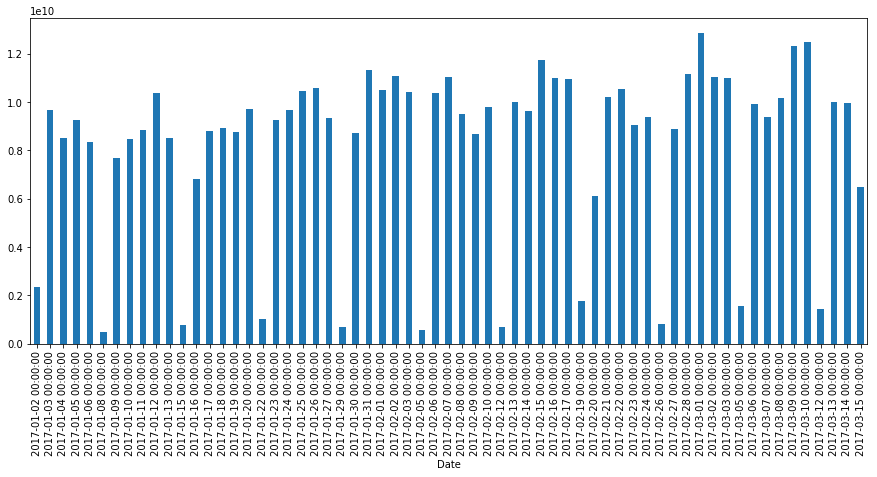

In [67]:
# I have the value for the valume transactions in the pair, so I decided to plot for learning purposes the mean value
# along 5000 registers, which means around 63 days.

# Days.
volume_day = data_eurusd_1[:5000].groupby('Date')['Volume'].mean()
volume_day.plot.bar(figsize=[15,6])

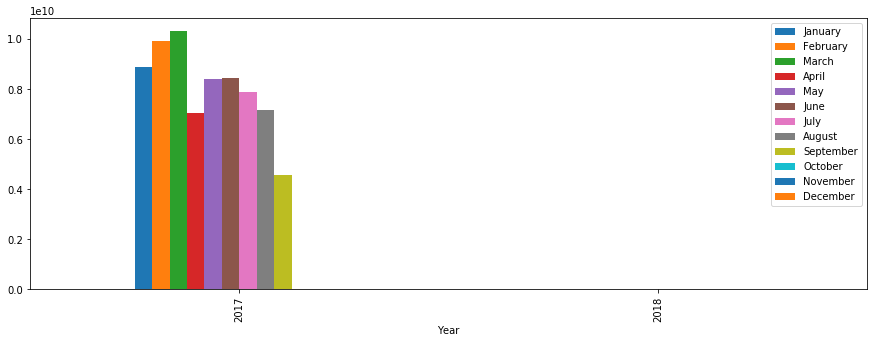

In [69]:
# Also I plot the mean volume value for each month in the year, I have to add a filter for the year that has
# enough registers. 
fig, ax = plt.subplots(figsize=[15,5])
volume_year_month = pd.pivot_table(data_eurusd_1,index='Year',columns='Month',values='Volume')
volume_year_month.plot(kind='bar', ax=ax)
ax.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']);

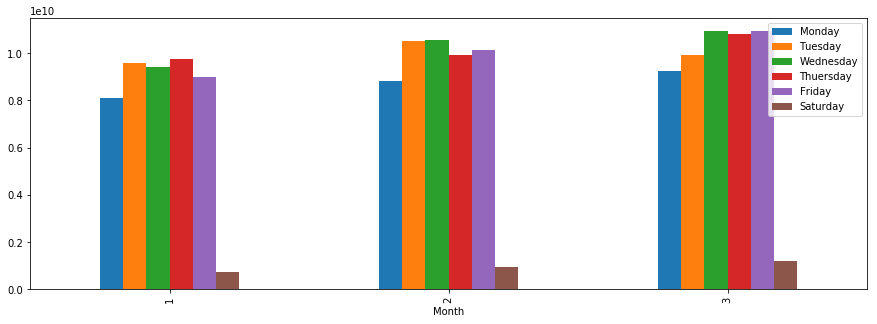

In [70]:
# For the mean value of volume by week day, the best aproach is to get a specific period range with the
# sub_dataset_date function.

fig, ax = plt.subplots(figsize=[15,5])
volume_year_month_day = sub_dataset_date('2017-01-05','2017-04-01')
volume_year_month_day = pd.pivot_table(volume_year_month_day,index='Month',columns='Day',values='Volume')
#volume_year_month_day
volume_year_month_day.plot(kind='bar', ax=ax)
ax.legend(['Monday','Tuesday','Wednesday','Thuersday','Friday','Saturday','Sunday']);

## Loading a second dataset.

In [71]:
# Now for some of my aims I start to clean another dataset with Donald Trump tweets.

tweets_DT = pd.read_csv('./Data/DonaldTrumpTweets2015_2019.csv')
tweets_DT.head(3)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,....be leaving office on August 15th. I would ...,07-28-2019 20:45:50,9434,43717,False,1155580142225383425
1,Twitter for iPhone,I am pleased to announce that highly respected...,07-28-2019 20:45:49,14945,59699,False,1155580140392501248
2,Twitter for iPhone,Under the Trump Administration African America...,07-28-2019 19:34:35,17057,69688,False,1155562212032991233


In [76]:
# Exploring types of data.
tweets_DT.dtypes

source            object
text              object
created_at        object
retweet_count      int64
favorite_count     int64
is_retweet        object
id_str             int64
dtype: object

In [77]:
# Checking if there are null values
missing_values_twt = tweets_DT.isna().sum()
missing_values_twt

source             0
text               0
created_at         0
retweet_count      0
favorite_count     0
is_retweet        58
id_str             0
dtype: int64

In [80]:
# I applied a similar re-structuration of the previous dataset in order to manage in an easy way the date and 
# time data.

def generate_date_2(x):
    date_time = x.split(' ')
    date = date_time[0].split('-')
    return datetime(year=int(date[2]), month=int(date[0]), day=int(date[1]))

def generate_time_2(x):
    date_time = x.split(' ')
    hour_minutes= date_time[1].split(':')
    if len(hour_minutes[0])==1:
        hour_minutes[0] = '0'+ hour_minutes[0]
        
    if int(hour_minutes[1])%15 == 0:
        hour_minutes[1] = hour_minutes[1]
    elif int(hour_minutes[1])%15 <= 7:
        hour_minutes[1] = str(int(hour_minutes[1]) - (int(hour_minutes[1])%15))
    elif int(hour_minutes[1])%15 > 7:
        hour_minutes[1] = str(int(hour_minutes[1]) + (15-int(hour_minutes[1])%15))
        
    if len(hour_minutes[1]) == 1:
        hour_minutes[1] = '0' + str(hour_minutes[1])
    if hour_minutes[1] == '60':
        hour_minutes[0] = str(int(hour_minutes[0]) + 1)
        if len(hour_minutes[0]) == 1:
            hour_minutes[0] = '0'+ hour_minutes[0]
        hour_minutes[1] = '00'
    if hour_minutes[0] == '24':
        hour_minutes[0] = '00'
    return ':'.join([str(hour_minutes[0]),str(hour_minutes[1])])

tweets_DT['round_time'] = tweets_DT.created_at.apply(generate_time_2)
tweets_DT['Date'] = tweets_DT.created_at.apply(generate_date_2)
tweets_DT.head(5)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,round_time,Date
0,Twitter for iPhone,....be leaving office on August 15th. I would ...,07-28-2019 20:45:50,9434,43717,False,1155580142225383425,20:45,2019-07-28
1,Twitter for iPhone,I am pleased to announce that highly respected...,07-28-2019 20:45:49,14945,59699,False,1155580140392501248,20:45,2019-07-28
2,Twitter for iPhone,Under the Trump Administration African America...,07-28-2019 19:34:35,17057,69688,False,1155562212032991233,19:30,2019-07-28
3,Twitter for iPhone,If racist Elijah Cummings would focus more of ...,07-28-2019 19:18:20,18208,71035,False,1155558122163003393,19:15,2019-07-28
4,Twitter for iPhone,There is nothing racist in stating plainly wha...,07-28-2019 18:35:09,27797,110425,False,1155547255916642305,18:30,2019-07-28


In [81]:
# I dropped a columns which has not valuable info.
tweets_DT = tweets_DT.drop(['id_str'],axis=1)

In [82]:
# With the null values in the column "is_retweet" I change for the string 'Unknown'
tweets_DT['is_retweet'] = tweets_DT['is_retweet'].fillna('Unknown')
tweets_DT.head(5)

,source,text,created_at,retweet_count,favorite_count,is_retweet,round_time,Date
0,Twitter for iPhone,....be leaving office on August 15th. I would ...,07-28-2019 20:45:50,9434,43717,False,20:45,2019-07-28
1,Twitter for iPhone,I am pleased to announce that highly respected...,07-28-2019 20:45:49,14945,59699,False,20:45,2019-07-28
2,Twitter for iPhone,Under the Trump Administration African America...,07-28-2019 19:34:35,17057,69688,False,19:30,2019-07-28
3,Twitter for iPhone,If racist Elijah Cummings would focus more of ...,07-28-2019 19:18:20,18208,71035,False,19:15,2019-07-28
4,Twitter for iPhone,There is nothing racist in stating plainly wha...,07-28-2019 18:35:09,27797,110425,False,18:30,2019-07-28


In [83]:
# More data manipulation for time column.
hour_tweet = lambda x: x[:2]
minutes_tweet = lambda x: x[3:5]
tweets_DT['Hour'] = tweets_DT.round_time.apply(hour_tweet)
tweets_DT['Minutes'] = tweets_DT.round_time.apply(minutes_tweet)

In [87]:
# I re-ordered the columns.
tweets_DT = tweets_DT[['Date','created_at','round_time','Hour','Minutes','text','is_retweet','retweet_count','favorite_count','source']]
tweets_DT.head(3)

,Date,created_at,round_time,Hour,Minutes,text,is_retweet,retweet_count,favorite_count,source
0,2019-07-28,07-28-2019 20:45:50,20:45,20,45,....be leaving office on August 15th. I would ...,False,9434,43717,Twitter for iPhone
1,2019-07-28,07-28-2019 20:45:49,20:45,20,45,I am pleased to announce that highly respected...,False,14945,59699,Twitter for iPhone
2,2019-07-28,07-28-2019 19:34:35,19:30,19,30,Under the Trump Administration African America...,False,17057,69688,Twitter for iPhone


In [96]:
# A fun fact in a chart, Which is the most common platform to tweet for Donald Trump? 
tweets_DT.source.value_counts()

Twitter for iPhone          10912
Twitter for Android          6503
Twitter Web Client           2008
Media Studio                  154
Twitter Ads                    97
Twitter for BlackBerry         84
Instagram                      64
Twitter Media Studio           60
Twitter for iPad               57
Twitter QandA                  10
Periscope                       7
Neatly For BlackBerry 10        5
TweetDeck                       2
Mobile Web (M5)                 1
Twitter Mirror for iPad         1
Facebook                        1
Name: source, dtype: int64

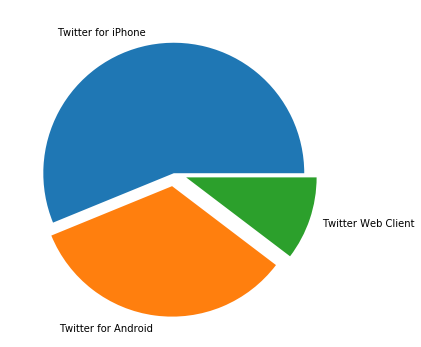

In [105]:
explode = (0, 0.1, 0.1)
fig,axS = plt.subplots(1,1,figsize=[6,6])
axS.pie(tweets_DT.source.value_counts()[:3],explode=explode,labels=['Twitter for iPhone', 'Twitter for Android', 'Twitter Web Client']);

<BarContainer object of 24 artists>

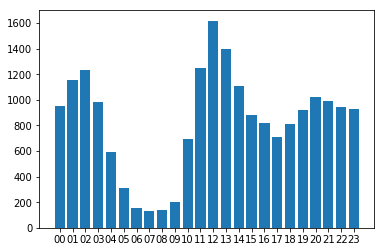

In [106]:
# Some info about the distribution of Donald trump tweet hour.
hora_preferida = tweets_DT.groupby('Hour')['text'].count()
fig,ax = plt.subplots(1,1)
ax.bar(hora_preferida.index,hora_preferida)

<BarContainer object of 4 artists>

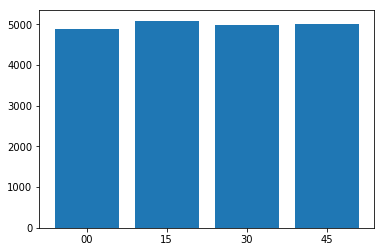

In [107]:
# In the next chart we can not see a strange distribution in the cuarter of hour at the tweet post, just a very little
# preference for the start of the hour.
cuarto_hora_fav = tweets_DT.groupby('Minutes')['text'].count()
fig,ax2 = plt.subplots(1,1)
ax2.bar(cuarto_hora_fav.index,cuarto_hora_fav)

In [108]:
# Para este punto hemos visualizado algunos de los atributos del dataset, sin embargo nos
# interesa ver un poco dentro del atributo de texto de cada tweet, para eso obtendremos las palabras más usadas 
# dentro de los tweets de DT.

# Primero generamos un archivo de texto plano sobre el cual aplicaremos algunas expresiones regulares para
# obtener palabras más limpias.

file1 = open("TweetsDT.txt","w")   
# \n is placed to indicate EOL (End of Line)  
file1.writelines(tweets_DT.text) 
file1.close() #to change file access modes 

In [109]:
# Leemos el archivo de texto.
file1 = open("TweetsDT.txt","r")
tweets_text = file1.read()
file1.close()

In [110]:
def complete_split(text_tweets):    
    words = []
    tempWords =[]
    for tweet in text_tweets:
        words.extend(tweet.split(' '))
    for word in words:
        if '\n' in word:
            tempWords.extend(word.split('\n'))
        else:
            tempWords.append(word)
    return tempWords

def complete_split_one(text_tweet):    
    words = []
    tempWords =[]
    words.extend(text_tweet.split(' '))
    for word in words:
        if '\n' in word:
            tempWords.extend(word.split('\n'))
        else:
            tempWords.append(word)
    return tempWords

words = complete_split(tweets_DT.text)

In [112]:
# Para limpiar el set de palabras observamos que se repiten regularmente los links hacia contenido externo,
# los usuarios nombrados con @..., tenemos los hashtags
def get_groups(list_words):
    pure_links = []
    links_hash = []
    pure_hash = []
    pure_words = []
    pure_refs = []
    for word in list_words:
        if ('http' in word and not('#' in word)):
            pure_links.append(word)
        elif ('http' in word and '#' in word):
            links_hash.append(word)
        elif ('#' in word):
            pure_hash.append(word)
        elif ('@' in word):
            if word[0] != '@':
                if word[-1].isalnum():
                    pure_refs.append(word[1:])
                else:
                    if word[-1] == '_':
                        pure_refs.append(word[1:])
                    else:
                        pure_refs.append(word[1:-1])
            else:
                if word[-1].isalnum():
                    pure_refs.append(word)
                else:
                    if word[-1] == '_':
                        pure_refs.append(word)
                    else:
                        pure_refs.append(word[:-1])
        else:
            pure_words.append(word)
    return [pure_words,pure_refs,pure_hash,pure_links,links_hash]

groups = get_groups(words)

In [113]:
# Despues de crear un set para: hashtags,words,references
set_words = set(groups[0])
set_hashs = set(groups[2])
set_refs = set(groups[1])

print("""Número de palabras: %i
Número de hashtags: %i
Número de menciones: %i
Número de links posteados: %i""" % (len(set_words),len(set_hashs),len(set_refs),len(groups[3])))

Número de palabras: 40680
Número de hashtags: 2139
Número de menciones: 7051
Número de links posteados: 6666


In [119]:
# Eliminamos signos de puntuación y simbolos no alfa numericos de las palabras.
elim_non_alphanum = lambda x: re.sub(r'[\W_]+','',x).lower()
words_alphanum = set(list(map(elim_non_alphanum,list(groups[0]))))
len(words_alphanum)

19890

In [120]:
# Obtenemos una lista de StopWords
from sklearn.feature_extraction import stop_words

In [121]:
list_stsopwords = list(stop_words.ENGLISH_STOP_WORDS)

In [122]:
# De la lista que obtuvimos de palabras en los tweets, eliminamos las stopwords
words_clean = [word for word in list(words_alphanum) if word not in list_stsopwords]
len(words_clean)

19595

In [123]:
# Finalmente tenemos las palabras que usaremos para medir la frecuencia en el total de tweets que tenemos.
# De la lista pure_words
pure_words_lower = list(map(lambda x: x.lower(),groups[0]))
freq_tweets_dict = {k:groups[0].count(k) for k in words_clean}
# Eliminamos el conteo de caracteres vacios.
del freq_tweets_dict[""]

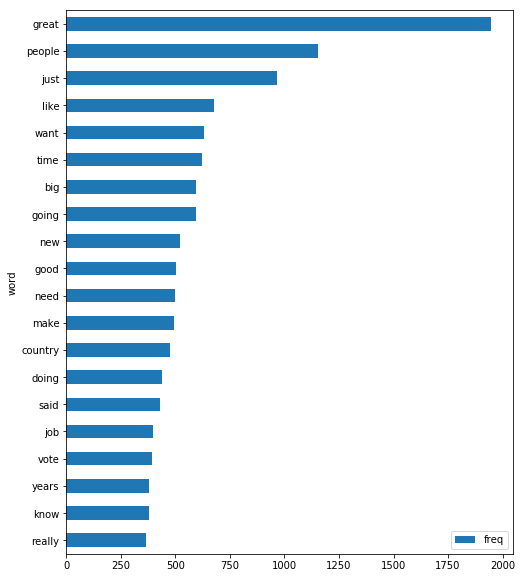

In [124]:
df = pd.DataFrame(freq_tweets_dict.items(), columns=['word', 'freq'])
most_frequent_words = df.sort_values('freq',ascending=True)[-20:]
most_frequent_words.plot.barh('word','freq',figsize=[8,10])

In [134]:
# Uno de nuestros objetivos es poder visualizar de manera simple, si algún tweet ha afectado el par EUR/USD
# Seleccionamos un tweet
tweet_selected = tweets_DT.iloc[8000]
tweet_selected

Date                                            2017-08-08 00:00:00
created_at                                      08-08-2017 18:10:18
round_time                                                    18:15
Hour                                                             18
Minutes                                                          15
text              After 200 days rarely has any Administration a...
is_retweet                                                    False
retweet_count                                                 25703
favorite_count                                               111343
source                                           Twitter for iPhone
Name: 8000, dtype: object

In [135]:
# Con base en su fecha
date_tw_selected = tweet_selected.Date
date_tw_selected

Timestamp('2017-08-08 00:00:00')

In [138]:
# Generamos una vecindad a su alrededor.
date_before_tweet = (date_tw_selected - timedelta(days = 2))
date_after_tweet = (date_tw_selected + timedelta(days = 2))

In [172]:
# Grafico de la vecindad al tweet
aroundtweet = sub_dataset_date(date_before_tweet,date_after_tweet)

fig3 = go.Figure(data=[go.Candlestick(x=aroundtweet['Date_Time'],
                open=aroundtweet['Open'],
                high=aroundtweet['High'],
                low=aroundtweet['Low'],
                close=aroundtweet['Close'])])

fig3.layout.update(title='Tweet on %s' % date_tw_selected)

fig3.iplot()

# Ubicamos y agregamos la información del tweet.


I can not add annotations for the chart :(, so I can't show the exact moment of the tweet embedded in the same chart but I add a title to have more handleable the date of the tweet analized. And again at this point I started to mixed some notes and comments in spanish and english.

In [140]:
# Al haber hubicado la frecuencia de las palabras en el conjunto total de los tweets, es interesante
# observar cuales son los tweets con un mayor número de palabras frecuentes.
def count_f_words(tweet):
    tweet_words = complete_split_one(tweet)
    groups_tweet = get_groups(tweet_words)
    tweet_words = map(lambda x: x.lower(),groups_tweet[0])
    tweet_words_alphanum = list(map(elim_non_alphanum,list(tweet_words)))
    tweet_words_clean = [word for word in list(tweet_words_alphanum) if word not in list_stsopwords]
    num_freq_words = [1 for word_t in tweet_words_clean if word_t in list(most_frequent_words.word)]
    return sum(num_freq_words)

In [142]:
tweets_DT['count_freq_words'] = tweets_DT.text.apply(count_f_words)

In [143]:
tweets_DT[tweets_DT.count_freq_words > 3]

,Date,created_at,round_time,Hour,Minutes,text,is_retweet,retweet_count,favorite_count,source,count_freq_words
4,2019-07-28,07-28-2019 18:35:09,18:30,18,30,There is nothing racist in stating plainly wha...,False,27797,110425,Twitter for iPhone,4
42,2019-07-26,07-26-2019 16:32:42,16:30,16,30,France just put a digital tax on our great Ame...,False,44806,184154,Twitter for iPhone,4
62,2019-07-25,07-25-2019 12:07:27,12:00,12,00,President Trump’s Approval Rating on Economy i...,False,18413,84100,Twitter for iPhone,4
143,2019-07-22,07-22-2019 12:31:46,12:30,12,30,The Amazon Washington Post front page story ye...,False,15717,71971,Twitter for iPhone,4
155,2019-07-21,07-21-2019 12:07:32,12:00,12,00,I don’t believe the four Congresswomen are cap...,False,41095,183231,Twitter for iPhone,4
207,2019-07-19,07-19-2019 12:34:52,12:30,12,30,....Governor of the State did a good job. Tha...,False,14105,80835,Twitter for iPhone,4
224,2019-07-18,07-18-2019 15:10:20,15:15,15,15,Most of the MS-13 Gang members indicted &amp; ...,False,24568,108442,Twitter for iPhone,4
227,2019-07-18,07-18-2019 14:46:33,14:45,14,45,Most of the MS-13 Gang members indictedand &am...,False,4348,16369,Twitter for iPhone,4
229,2019-07-18,07-18-2019 03:51:19,03:45,03,45,Just returned to the White House from the Grea...,False,25232,132379,Twitter for iPhone,5
239,2019-07-17,07-17-2019 12:46:13,12:45,12,45,Big Rally tonight in Greenville North Carolina...,False,24103,108954,Twitter for iPhone,4


In [144]:
# Antes de continuar seria importante tener una versión limpia de cada tweet, eliminando los links.
def clean_tweet(tweet):
    tweet_words = complete_split_one(tweet)
    groups_tweet = get_groups(tweet_words)
    if groups_tweet[4] != []:
        groups_tweet[2].extend(re.findall(r'#\w+',' '.join(groups_tweet[4])))
    #tweet_clean_r = ' '.join([' '.join(groups_tweet[0]),' '.join(groups_tweet[1]),' '.join(groups_tweet[2])])
    tweet_clean_r = ' '.join(groups_tweet[0])
    return tweet_clean_r

In [146]:
tweets_DT['tweet_clean'] = tweets_DT.text.apply(clean_tweet)

In [147]:
# Es entendible que no todos los tweets generados por Donald Trump repercuten sobre el par EUR/USD,
# es probable,incluso, que ninguno repercuta. Sin embargo intentemos utilizar un método de clustering
# para identificar algún grupo interesante que visualmente represente un factor cercano a un cambio en el par.

# Utilizamos un método de clustering (Por ahora solo busqué algo que funcione a pesar de no entenderlo completamente),
# esperando ver este tipo de temas más a fondo durante el bootcamp.

# Método 

#Latent Dirichlet Allocation (LDA)
#The LDA is based upon two general assumptions:

#Documents that have similar words usually have the same topic
#Documents that have groups of words frequently occurring together usually have the same topic.
#These assumptions make sense because the documents that have the same topic, for instance, Business topics will have words like the "economy", "profit", "the stock market", "loss", etc. The second assumption states that if these words frequently occur together in multiple documents, those documents may belong to the same category.

#Mathematically, the above two assumptions can be represented as:

#Documents are probability distributions over latent topics
#Topics are probability distributions over words

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(tweets_DT['tweet_clean'].values.astype('U'))


In [149]:
doc_term_matrix

<19966x9039 sparse matrix of type '<class 'numpy.int64'>'
	with 207604 stored elements in Compressed Sparse Row format>

In [156]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=15, random_state=23)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=15, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=23, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [151]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['times', 'great', 'rt', 'just', 'happy', 'york', 'donald', 'poll', 'new', 'trump']


Top 10 words for topic #1:
['job', 'presidential', 'congratulations', 'endorsement', 'big', 'vote', 'state', 'amp', 'win', 'great']


Top 10 words for topic #2:
['bad', 'just', 'said', 'amp', 'crooked', 'media', 'clinton', 'fake', 'news', 'hillary']


Top 10 words for topic #3:
['cuts', 'work', 'forward', 'country', 'today', 'amp', 'tax', 'make', 'america', 'great']


Top 10 words for topic #4:
['00', 'tomorrow', 'just', 'amazing', 'enjoy', 'night', 'join', 'tonight', 'great', 'thank']


Top 10 words for topic #5:
['called', 'pay', 'doing', 'iran', 'american', 'obama', 'rt', 'people', 'amp', 'just']


Top 10 words for topic #6:
['illegal', 'mexico', 'people', 'want', 'immigration', 'country', 'security', 'wall', 'democrats', 'border']


Top 10 words for topic #7:
['great', 'doesn', 'bad', 'good', 'money', 'people', 'just', 'news', 'amp', 'don']


Top 10 words for topic #8:
[

Es complicado encontrar un grupo especifico de tweets que puedan considerarse más probables de influenciar el par EUR/USD. La generación de temas con el método descrito anteriormente tiene un enfoque no supervisado, por lo cual se debe inferir, a partir de las palabras más comunes en la categoría, cuál es el tema.

In [174]:
# Sin embargo agregamos las categorías encontradas al dataset.
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(19966, 15)

In [153]:
tweets_DT['Topic'] = topic_values.argmax(axis=1)
tweets_DT.tail(5)

,Date,created_at,round_time,Hour,Minutes,text,is_retweet,retweet_count,favorite_count,source,count_freq_words,tweet_clean,Topic
19961,2015-01-01,01-01-2015 07:05:27,07:00,07,00,@yankeejayman: @realDonaldTrump @flicka__ Do u...,False,11,38,Twitter for Android,0,Do u ever sleep? Not much!,0
19962,2015-01-01,01-01-2015 07:04:45,07:00,07,00,@TalentlessCook: @realDonaldTrump You're only ...,False,17,56,Twitter for Android,1,You're only a year away from ...pick a running...,13
19963,2015-01-01,01-01-2015 07:04:33,07:00,07,00,@archangeljf12: ;@realDonaldTrump for Preside...,False,24,56,Twitter for Android,0,for President of the United States! Vice Pres...,8
19964,2015-01-01,01-01-2015 07:02:39,07:00,07,00,The Mar-a-Lago Club was amazing tonight. Every...,False,27,77,Twitter for Android,0,The Mar-a-Lago Club was amazing tonight. Every...,13
19965,2015-01-01,01-01-2015 06:54:59,07:00,07,00,@flicka__: @realDonaldTrump for president,False,18,58,Twitter for Android,0,for president,12


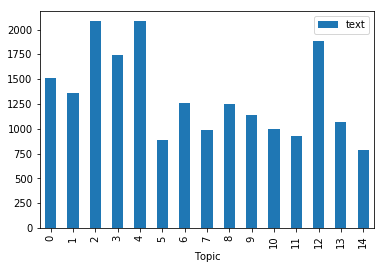

In [175]:
# Una distribución a partir de las categorías encontradas.
tweets_DT[['text','Topic']].groupby('Topic').count().plot.bar()

Finalmente no logre el objetivo principal de observar la influencia de los tweets de Donald Trump sobre el par EUR/USD de manera visual, esta tarea resulta complicada para un proyecto con limitado tiempo. Sin embargo practique mis conocimientos sobre la visualización con diferentes gráficos.